In [26]:
import torch
from pathlib import Path
import pandas as pd
import io
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True)
# labels 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


length of training set: 50000
length of test set: 10000
this is an image of a frog


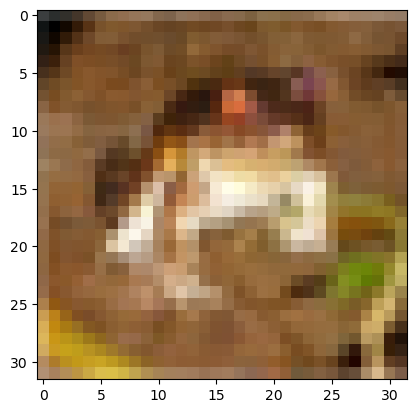

In [6]:
print('length of training set: ' + str(len(trainset)))
print('length of test set: ' + str(len(testset)))
example = 0
image, label = trainset[example] #since each element of the trainset list is itself a tuple with the image details, and then the label
print("this is an image of a " + classes[(trainset[example])[1]]) # first index into tuple in trainset, then the 2nd value (label), and then the classes
plt.imshow(image)

In [7]:
datasetT = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transforms.ToTensor())

Files already downloaded and verified


R channel of image 0 in dataset


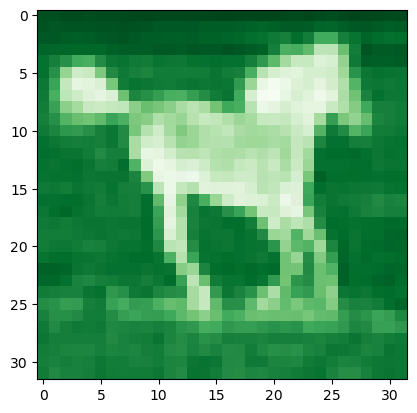

In [8]:
example = 21344
imgTensor, label = datasetT[example]
plt.imshow(imgTensor[1, 0:32, 0:32], cmap='Greens')
# change the 0 to 1 or 2 for different color channels.
print("R channel of image 0 in dataset")


In [16]:
#length of training examples.
m = 50000 

#percentage of m dedicated to CV.  
pCV = 0.2

# give the amount of examples dedicated to CV. 
mCV = int(m*pCV)
print("amount of training examples: " + str(m - mCV))
print("amount of cross validation examples: " + str(mCV))


amount of training examples: 40000
amount of cross validation examples: 10000


In [17]:
def splitIndices(m, pCV):
  """ randomly shuffle a training set's indices, then split the indices into training and cross validation sets.
   Pass in 'm', length of training set, and 'pCV', the percentage of the training set you would like 
   to dedicate to cross validation."""
   
  # determine size of CV set.
  mCV = int(m*pCV)

  #create random permutation of 0 to m-1 - randomly shuffle all values from 0 to m.
  indices = np.random.permutation(m)

  #pick first mCV indices for training, and then validation.
  return indices[mCV:], indices[:mCV]


In [18]:
trainIndices, valIndices = splitIndices(m, pCV)

In [20]:
batchSize = 100

# TRAIN SET

# training sampler and data loader - creates a SubsetRandomSampler object that takes random samples of the numbers in trainIndices, or random indices.
trainSampler = SubsetRandomSampler(trainIndices)


# training loader - creates a dataloader object which takes the indices from trainSampler, 
# and when given batchSize, takes random batches of batchSize from the indices list, and then pairs it with
# the respective dataset in datasetT
trainLoader = DataLoader(datasetT, batchSize, sampler=trainSampler)

print(list(trainLoader))

# VALIDATION SET

valSampler = SubsetRandomSampler(valIndices)
valLoader = DataLoader(datasetT, batchSize, sampler=valSampler)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [22]:
# this will dictate the rows of the theta matrix
inputSize = 3*32*32

# this will dictate the columns of the theta matrix
numClasses = 10

# create our linear regression model (nn.Linear creates bias terms for us)
model = nn.Linear(inputSize, numClasses)

In [23]:
print('dimensions of weight matrix: ' + str(model.weight.shape))
print(model.weight)
print('dimensions of bias matrix: ' + str(model.bias.shape))
print(model.bias)

dimensions of weight matrix: torch.Size([10, 3072])
Parameter containing:
tensor([[ 0.0036, -0.0080, -0.0063,  ..., -0.0124, -0.0071, -0.0138],
        [ 0.0162,  0.0082,  0.0127,  ..., -0.0123,  0.0013, -0.0080],
        [-0.0142,  0.0076, -0.0133,  ...,  0.0065,  0.0123,  0.0044],
        ...,
        [-0.0010, -0.0067, -0.0057,  ...,  0.0149, -0.0148,  0.0174],
        [-0.0170,  0.0084, -0.0134,  ...,  0.0149, -0.0084,  0.0007],
        [ 0.0085,  0.0145, -0.0082,  ..., -0.0062,  0.0037,  0.0120]],
       requires_grad=True)
dimensions of bias matrix: torch.Size([10])
Parameter containing:
tensor([-0.0062,  0.0016, -0.0072,  0.0173, -0.0135, -0.0116,  0.0047,  0.0121,
         0.0133,  0.0131], requires_grad=True)


In [24]:
class CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(inputSize, numClasses)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 3072)
        out = self.linear(xb)
        return out
    
model = CIFAR10()

In [25]:
for images, labels in trainLoader:
  outputs = model(images)
  break

print('outputs.shape :', outputs.shape)
print('sample outputs :\n', outputs[:2]) # print 2 out of the 100 rows of the total output vector

outputs.shape : torch.Size([100, 10])
sample outputs :
 tensor([[ 0.2070, -0.0774,  0.4415, -0.0370, -0.1347,  0.4828, -0.0093,  0.0576,
          0.2257,  0.0261],
        [ 0.1938, -0.0978,  0.4522, -0.2203, -0.0817,  0.1911, -0.0268,  0.0401,
          0.0973,  0.0392]], grad_fn=<SliceBackward0>)


In [27]:
# apply the softmax for each output row in our 100 x 10 output (with batch size 100)
probs = F.softmax(outputs, dim=1)

# look at some sample probabilities
print("sample probabilities:\n", probs[:2].data)
# add up the probabilities of each row for a sanity check that they equal 1 now
print(sum(list(probs[0])))

sample probabilities:
 tensor([[0.1070, 0.0805, 0.1352, 0.0838, 0.0760, 0.1409, 0.0862, 0.0921, 0.1090,
         0.0893],
        [0.1126, 0.0841, 0.1458, 0.0744, 0.0855, 0.1123, 0.0903, 0.0965, 0.1022,
         0.0964]])
tensor(1., grad_fn=<AddBackward0>)


In [30]:
maxProbs, preds = torch.max(probs, dim=1) #torch.max returns the max value itself (maxProbs) as well as the index of the prediction (preds)
print(preds)
print(maxProbs)
labels==preds

tensor([5, 2, 5, 5, 5, 2, 5, 5, 5, 5, 5, 2, 2, 5, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5,
        5, 5, 5, 5, 0, 2, 5, 5, 2, 5, 2, 2, 5, 6, 2, 2, 5, 2, 5, 5, 5, 5, 5, 2,
        5, 2, 5, 5, 5, 5, 5, 2, 5, 5, 5, 5, 2, 2, 5, 2, 5, 5, 5, 2, 2, 5, 2, 5,
        0, 5, 5, 5, 5, 2, 5, 2, 2, 5, 0, 5, 5, 5, 5, 5, 5, 2, 5, 2, 5, 5, 5, 5,
        5, 5, 5, 0])
tensor([0.1409, 0.1458, 0.1529, 0.1507, 0.1392, 0.1589, 0.1378, 0.1424, 0.1465,
        0.1423, 0.1411, 0.1346, 0.1736, 0.1205, 0.1527, 0.1350, 0.1406, 0.1488,
        0.1401, 0.1481, 0.1568, 0.1359, 0.1596, 0.1490, 0.1405, 0.1520, 0.1389,
        0.1237, 0.1307, 0.1429, 0.1365, 0.1331, 0.1387, 0.1479, 0.1392, 0.1410,
        0.1509, 0.1289, 0.1344, 0.1461, 0.1481, 0.2075, 0.1380, 0.1550, 0.1603,
        0.1382, 0.1421, 0.1319, 0.1373, 0.1636, 0.1281, 0.1312, 0.1465, 0.1439,
        0.1526, 0.1294, 0.1386, 0.1746, 0.1541, 0.1630, 0.1396, 0.1399, 0.1630,
        0.1629, 0.1257, 0.1401, 0.1336, 0.1558, 0.1442, 0.1240, 0.1210, 0.1564,
        0.1203, 0.1

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False,  True, False, False, False,
         True, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False,  True,  True, False, False, False, False, False, False])

In [31]:
def accuracy(preds, labels):
  return torch.sum(labels==preds).item() / len(labels)

In [32]:
accuracy(preds, labels)

0.09

In [33]:
lossFn = F.cross_entropy
# loss for current batch of data
# remember that outputs are our thetas gathered from the model
# labels is correct answers from dataLoader
loss = lossFn(outputs, labels)
print(loss)

tensor(2.3532, grad_fn=<NllLossBackward0>)


In [34]:
learningRate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [35]:
# recall that xb is the X (a list batchSize long of 3x32x32 images) for a batch. yb is the corresponding labels for those images.

def lossBatch(model, lossFn, xb, yb, opt=None, metric=None):
  # calculate the loss
  preds = model(xb)
  loss = lossFn(preds, yb)

  if opt is not None:
    # compute gradients
    loss.backward()
    # update parameters
    opt.step()
    # reset gradients to 0 (don't want to calculate second derivatives!)
    opt.zero_grad()

  metricResult = None
  if metric is not None:
    metricResult = metric(preds, yb)

  return loss.item(), len(xb),  metricResult

In [36]:
def evaluate(model, lossFn, validDL, metric=None):
  #with torch.no_grad (this was causing an error)
  
  # pass each batch of the validation set through the model to form a multidimensional list (holding loss, length and metric for each batch)
  # the reason why we made optimization optional is so we can reuse the function here
  results = [lossBatch(model, lossFn, xb, yb, metric=metric,) for xb,yb in validDL]

  # separate losses, counts and metrics
  losses, nums, metrics = zip(*results)

  # total size of the dataset (we keep track of lengths of batches since dataset might not be perfectly divisible by batch size)
  total = np.sum(nums)

  # find average total loss over all batches in validation (remember these are all vectors doing element wise operations.)
  avgLoss = np.sum(np.multiply(losses, nums))/total

  # if there is a metric passed, compute the average metric
  if metric is not None:
    # avg of metric accross batches
    avgMetric = np.sum(np.multiply(metrics, nums)) / total

  return avgLoss, total, avgMetric

In [37]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1) # underscore discards the max value itself, we don't care about that
  return torch.sum(preds == labels).item() / len(preds)

In [38]:
E = evaluate(model, lossFn, valLoader, metric=accuracy)

print("training set loss: ", loss)
print("cross validation set loss: ", E[0])

training set loss:  tensor(2.3532, grad_fn=<NllLossBackward0>)
cross validation set loss:  2.32290647983551


In [39]:
def fit(epochs, model, lossFn, opt, trainDL, valDL, metric=None):
  valList = [0.10]
  for epoch in range(epochs):
    # training - perform one step gradient descent on each batch, then moves on
    for xb, yb in trainDL: 
      loss,_,lossMetric = lossBatch(model, lossFn, xb, yb, opt)
      

    # evaluation on cross val dataset - after updating over all batches, technically one epoch
    # evaluates over all validation batches and then calculates average val loss, as well as the metric (accuracy)
    valResult = evaluate(model, lossFn, valDL, metric)
    valLoss, total, valMetric = valResult
    valList.append(valMetric)
    # print progress
    if metric is None: 
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, epochs, valLoss))
    else:
      print('Epoch [{}/{}], Loss: {:.4f}, {}: {:.4f}'.format(epoch + 1, epochs, valLoss, metric.__name__, valMetric))

  return valList

In [40]:
# redefine model and optimizer
learningRate = 0.009
model = CIFAR10()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)

In [41]:
trainList = fit(100, model, lossFn, optimizer, trainLoader, valLoader, metric=accuracy)

Epoch [1/100], Loss: 1.9143, accuracy: 0.3200
Epoch [2/100], Loss: 1.8531, accuracy: 0.3598
Epoch [3/100], Loss: 1.8410, accuracy: 0.3494
Epoch [4/100], Loss: 1.8117, accuracy: 0.3741
Epoch [5/100], Loss: 1.8287, accuracy: 0.3645
Epoch [6/100], Loss: 1.7907, accuracy: 0.3812
Epoch [7/100], Loss: 1.8001, accuracy: 0.3765
Epoch [8/100], Loss: 1.7920, accuracy: 0.3826
Epoch [9/100], Loss: 1.8139, accuracy: 0.3631
Epoch [10/100], Loss: 1.7719, accuracy: 0.3844
Epoch [11/100], Loss: 1.7763, accuracy: 0.3810
Epoch [12/100], Loss: 1.7684, accuracy: 0.3855
Epoch [13/100], Loss: 1.7835, accuracy: 0.3814
Epoch [14/100], Loss: 1.7578, accuracy: 0.3917
Epoch [15/100], Loss: 1.7748, accuracy: 0.3809
Epoch [16/100], Loss: 1.7642, accuracy: 0.3854
Epoch [17/100], Loss: 1.7737, accuracy: 0.3868
Epoch [18/100], Loss: 1.7955, accuracy: 0.3817
Epoch [19/100], Loss: 1.7512, accuracy: 0.3979
Epoch [20/100], Loss: 1.7580, accuracy: 0.3970
Epoch [21/100], Loss: 1.7612, accuracy: 0.3963
Epoch [22/100], Loss: 

In [42]:
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=torchvision.transforms.ToTensor())
testLoader = DataLoader(test, batchSize)

Files already downloaded and verified


In [43]:
avgLoss, total, avgMetric = evaluate(model, F.cross_entropy, testLoader, metric=accuracy)
print("test set accuracy: \n", avgMetric)
avgLoss, total, avgMetric = evaluate(model, F.cross_entropy, valLoader, metric=accuracy)
print("cross validation set accuracy: \n",avgMetric)
avgLoss, total, avgMetric = evaluate(model, F.cross_entropy, trainLoader, metric=accuracy)
print("training set accuracy: \n",avgMetric)

test set accuracy: 
 0.3968
cross validation set accuracy: 
 0.4014
training set accuracy: 
 0.444925
